In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from time import time
from operator import itemgetter

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

PLOT = True
SELECT_YEAR = 2017

DATA_PATH = './data'
PLOT_PATH = './docs/plots/{}'.format(SELECT_YEAR)


In [2]:
# Data Read
data_file = '{}/{}_lattes.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df = pd.read_pickle(data_file, compression='xz')
print('{} docs shape'.format(df.shape))
df.head(10)

CPU times: user 180 ms, sys: 9.89 ms, total: 190 ms
Wall time: 200 ms
(8652, 4) docs shape


,id,titulo,clean,w_count
0,104124422364023,Exploiting photo location and direction for cl...,"[exploit, photo, locat, direct, cluster, base,...",9
1,104124422364023,A gold-standard social media corpus for urban ...,"[gold, standard, social, media, corpus, urban,...",8
2,104124422364023,A Framework for Spatial Analytics using Hetero...,"[framework, spatial, analyt, use, heterogen, d...",9
3,105670521813027,Gene expression analysis in Musa acuminata dur...,"[gene, express, analysi, musa, acuminata, comp...",12
4,105670521813027,Mitogenome sequence accuracy using different e...,"[mitogenom, sequenc, accuraci, use, differ, el...",7
5,109837868064895,A study of equivalent electrical circuit fitti...,"[studi, equival, electr, circuit, fit, electro...",14
6,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,"[dynam, connect, vessel, runaway, reaction, ri...",14
7,116792663386170,VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...,"[vle, base, dynam, simul, trickl, bed, reactor...",13
8,116792663386170,SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...,"[solubl, behavior, gamma, valerolacton, tetrad...",9
9,116792663386170,Removal of amoxicillin from water by adsorptio...,"[remov, amoxicillin, water, adsorpt, onto, act...",25


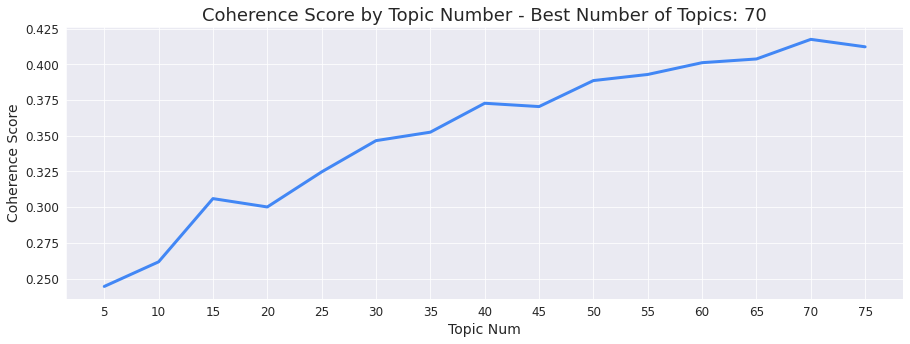

Time: 3.78 mins


In [3]:
# Use Gensim's NMF to get the best num of topics via coherence score

def graph_coherence(texts):
    # Create a dictionary
    # In gensim a dictionary is a mapping between words and their integer id
    dictionary = Dictionary(texts)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(
        no_below=3,
        no_above=0.85,
        keep_n=5000
    )

    # Create the bag-of-words format (list of (token_id, token_count))
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create a list of the topic numbers we want to try
    topic_nums = list(np.arange(5, 75 + 1, 5))

    # Run the nmf model and calculate the coherence score
    # for each number of topics
    coherence_scores = []

    for num in topic_nums:
        nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=dictionary,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=42
        )
        
        # Run the coherence model to get the score
        cm = CoherenceModel(
            model=nmf,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        
        coherence_scores.append(round(cm.get_coherence(), 5))

    # Get the number of topics with the highest coherence score
    scores = list(zip(topic_nums, coherence_scores))
    best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

    # Plot the results
    fig = plt.figure(figsize=(15, 5))

    plt.plot(
        topic_nums,
        coherence_scores,
        linewidth=3,
        color='#4287f5'
    )

    plt.xlabel("Topic Num", fontsize=14)
    plt.ylabel("Coherence Score", fontsize=14)
    plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
    plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
    plt.yticks(fontsize=12)

    file_name = '/{}_c_score'.format(SELECT_YEAR)

    fig.savefig(
        PLOT_PATH + file_name + '.png',
        dpi=fig.dpi,
        bbox_inches='tight'
    )

    plt.show()
    return best_num_topics

if PLOT:
    t = time()
    texts = df['clean']
    best_num_topics = graph_coherence(texts)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))
else:
    best_num_topics = 20

In [4]:
# Create the tfidf
texts = df['clean']

tfidf_vectorizer = TfidfVectorizer(
    min_df=0.0005,
    max_df=0.1,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf_fn = tfidf_vectorizer.get_feature_names()

print('vocabulary: {}'.format(len(tfidf_vectorizer.vocabulary_)))
print('sparse matrix shape: {}'.format(tfidf.shape))
print('nonzero count: {}'.format(tfidf.nnz))
print('sparsity: {:.3f}'.format(100.0 * tfidf.nnz / (tfidf.shape[0] * tfidf.shape[1])))

weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tfidf_vectorizer.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)



vocabulary: 3560
sparse matrix shape: (8652, 3560)
nonzero count: 74292
sparsity: 0.241


,term,weight
1991,model,0.017957
3123,system,0.016755
2107,network,0.016096
130,analysi,0.015714
792,data,0.013562
178,approach,0.012278
1725,learn,0.011064
3056,studi,0.010943
101,algorithm,0.010550
2925,softwar,0.010229


In [5]:
# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

def list_topics(model, feature_names, no_top_words):
    idx2word = np.array(feature_names)
    for i, topic in enumerate(model.components_):
        print('{:02d}: {}'.format(
            i + 1, ','.join([x for x in idx2word[topic.argsort()[:-no_top_words - 1:-1]]])))

list_topics(nmf,tfidf_fn,8)

01: servic,cloud,orient,platform,composit,servic orient,plan,fog
02: network,neural,neural network,convolut,convolut neural,artifici,artifici neural,social
03: develop,softwar develop,agil,develop team,team,develop process,agil softwar,identifi
04: model,model base,base model,driven,model use,model driven,forecast,estim
05: data,mine,data mine,stream,data stream,big,big data,link
06: system,embed,system base,embed system,system system,inform system,recommend system,system use
07: learn,reinforc learn,reinforc,deep,deep learn,learn environ,transfer,educ
08: analysi,compar,network analysi,analysi use,data analysi,social network,compar analysi,analysi base
09: studi,case,case studi,exploratori,compar studi,studi brazilian,exploratori studi,system case
10: imag,segment,recognit,imag segment,imag use,imag classif,reconstruct,hyperspectr
11: review,systemat,literatur,literatur review,systemat literatur,systemat review,review literatur,survey
12: evalu,perform,perform evalu,evalu use,usabl,ev

In [6]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["T%d_words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["T%d_wgt" % (topic_idx)]= ['{:.3f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

display_topics(nmf,tfidf_fn,10)


,T0_words,T0_wgt,T1_words,T1_wgt,T2_words,T2_wgt,T3_words,T3_wgt,T4_words,T4_wgt,...,T65_words,T65_wgt,T66_words,T66_wgt,T67_words,T67_wgt,T68_words,T68_wgt,T69_words,T69_wgt
0,servic,217.267,network,3.264,develop,4.907,model,3.410,data,4.031,...,low,1.538,recommend,1.883,inform,2.028,path,1.058,interact,1.954
1,cloud,58.491,neural,2.315,softwar develop,1.588,model base,0.355,mine,0.682,...,power,1.146,techniqu,1.006,character,0.941,identif,0.972,human,0.553
2,orient,54.897,neural network,2.218,agil,0.565,base model,0.243,data mine,0.653,...,cost,0.782,educ,0.625,inform system,0.389,forest,0.810,social,0.300
3,platform,40.484,convolut,1.019,develop team,0.387,driven,0.194,stream,0.553,...,low cost,0.662,compar,0.496,theori,0.338,optimum,0.596,digit,0.183
4,composit,36.980,convolut neural,0.979,team,0.343,model use,0.164,data stream,0.509,...,low power,0.469,recommend system,0.482,load,0.234,optimum path,0.591,multimod,0.177
5,servic orient,35.470,artifici,0.543,develop process,0.342,model driven,0.152,big,0.447,...,adder,0.215,confer,0.325,inform theori,0.210,path forest,0.581,user,0.175
6,plan,28.016,artifici neural,0.528,agil softwar,0.326,forecast,0.145,big data,0.393,...,devic,0.211,ecosystem,0.229,extract,0.206,classifi,0.428,human interact,0.167
7,fog,20.708,social,0.318,identifi,0.293,estim,0.142,link,0.233,...,hardwar,0.191,exploit,0.186,electr,0.176,diseas,0.270,express,0.153
8,failur,20.605,social network,0.285,game,0.291,valu,0.111,open data,0.199,...,video,0.167,item,0.162,flow,0.176,forest classifi,0.203,role,0.145
9,web,20.449,recognit,0.281,driven,0.278,process model,0.104,data analysi,0.197,...,compressor,0.162,user,0.152,quantifi,0.168,autom,0.166,base interact,0.144


In [7]:
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8
topic_df = topic_table(nmf, tfidf_fn, n_top_words).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(word_tokenize) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()


,0,1,2,3,4,5,6,7,topics
0,servic,cloud,orient,platform,composit,servic orient,plan,fog,servic cloud orient platform composit plan fog
1,network,neural,neural network,convolut,convolut neural,artifici,artifici neural,social,network neural convolut artifici social
2,develop,softwar develop,agil,develop team,team,develop process,agil softwar,identifi,develop softwar agil team process identifi
3,model,model base,base model,driven,model use,model driven,forecast,estim,model base driven use forecast estim
4,data,mine,data mine,stream,data stream,big,big data,link,data mine stream big link


In [8]:
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head(10)

,topic_num,topics
0,0,servic cloud orient platform composit plan fog
1,1,network neural convolut artifici social
2,2,develop softwar agil team process identifi
3,3,model base driven use forecast estim
4,4,data mine stream big link
5,5,system embed base inform recommend use
6,6,learn reinforc deep environ transfer educ
7,7,analysi compar network use data social base
8,8,studi case exploratori compar brazilian system
9,9,imag segment recognit use classif reconstruct ...


In [9]:
df_temp = pd.DataFrame({
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    left_index=True,
    right_index=True
)

df_topics = df_topics.drop(['w_count','clean'],axis=1)
df_topics.head(10)


,id,titulo,topic_num,topics
0,104124422364023,Exploiting photo location and direction for cl...,66,recommend techniqu educ compar system confer e...
1,104124422364023,A gold-standard social media corpus for urban ...,69,interact human social digit multimod user express
2,104124422364023,A Framework for Spatial Analytics using Hetero...,4,data mine stream big link
3,105670521813027,Gene expression analysis in Musa acuminata dur...,69,interact human social digit multimod user express
4,105670521813027,Mitogenome sequence accuracy using different e...,31,method element base equat numer appli
5,109837868064895,A study of equivalent electrical circuit fitti...,31,method element base equat numer appli
6,116792663386170,DYNAMICS OF CONNECTED VESSELS WITH RUNAWAY REA...,59,dynam strategi multipl molecular analysi knowl...
7,116792663386170,VLE BASED DYNAMIC SIMULATION OF A TRICKLE-BED ...,59,dynam strategi multipl molecular analysi knowl...
8,116792663386170,SOLUBILITY BEHAVIOR OF GAMMA-VALEROLACTONE + N...,65,low power cost adder devic hardwar
9,116792663386170,Removal of amoxicillin from water by adsorptio...,3,model base driven use forecast estim


In [10]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

A = 8652 x 3560
W = 70 x 3560
H = 8652 x 70


In [11]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 8228.702'

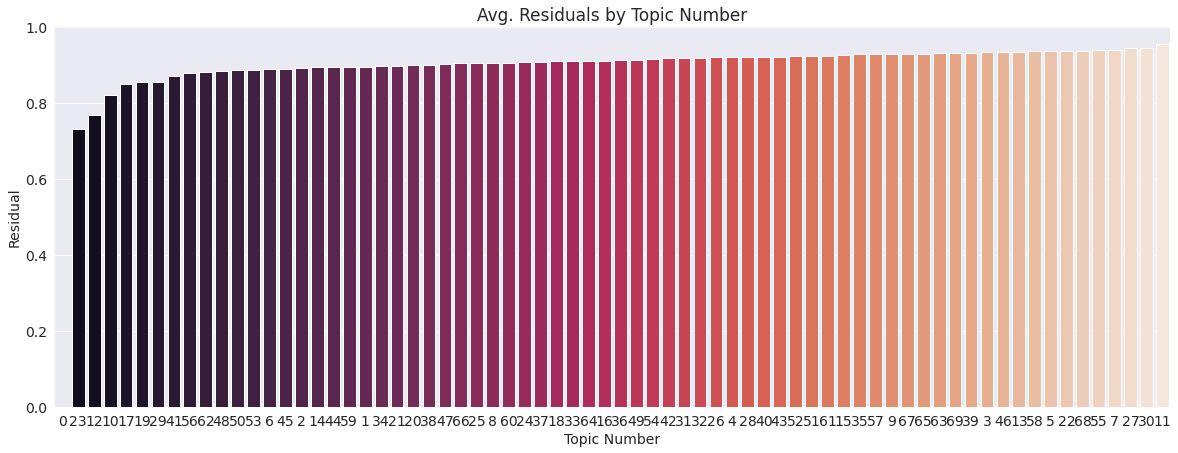

In [12]:
# Add the residuals to the df
df_topics['resid'] = r

# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = resid_data.index
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

file_name = '/{}_avg_resid'.format(SELECT_YEAR)

fig.savefig(
    PLOT_PATH + file_name + '.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

<Figure size 1080x360 with 0 Axes>

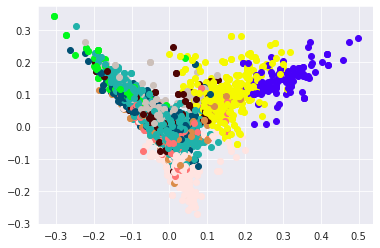

Time: 5.26 mins


In [13]:
# Create k-means model with custom config

def graph_KMeans(tfidf):
    num_clusters = 10
    num_seeds = 10
    max_iterations = 300
    labels_color_map = {
        0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
        5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
    }
    pca_num_components = 2

    clustering_model = KMeans(
        n_clusters=num_clusters,
        max_iter=max_iterations,
        precompute_distances="auto",
        n_jobs=-1
    )

    labels = clustering_model.fit_predict(tfidf)

    X = tfidf.todense()

    reduced_data = PCA(n_components=pca_num_components).fit_transform(X)

    fig = plt.figure(figsize=(15, 5))

    fig, ax = plt.subplots()
    for index, instance in enumerate(reduced_data):
        pca_comp_1, pca_comp_2 = reduced_data[index]
        color = labels_color_map[labels[index]]
        ax.scatter(pca_comp_1, pca_comp_2, c=color)

    file_name = '/{}_KMeans'.format(SELECT_YEAR)

    fig.savefig(
        PLOT_PATH + file_name + '.png',
        dpi=fig.dpi,
        bbox_inches='tight'
    )

    plt.show()

if PLOT:
    t = time()
    graph_KMeans(tfidf)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))

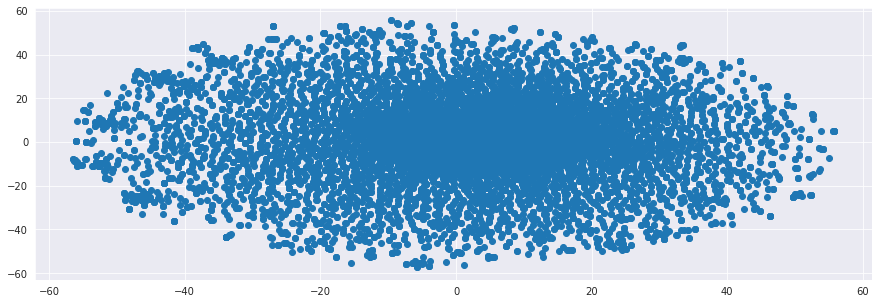

Time: 9.49 mins


In [14]:
# t-SNE plot

def graph_tsne(tfidf):
    X = tfidf.todense()
    tsne_num_components = 2
    embeddings = TSNE(n_components=tsne_num_components)
    Y = embeddings.fit_transform(X)

    fig = plt.figure(figsize=(15, 5))

    plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)

    file_name = '/{}_tsne'.format(SELECT_YEAR)

    fig.savefig(
        PLOT_PATH + file_name + '.png',
        dpi=fig.dpi,
        bbox_inches='tight'
    )

    plt.show()

if PLOT:
    t = time()
    graph_tsne(tfidf)
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))


In [15]:
# Save
path = '{}/'.format(DATA_PATH)

topics_file = '{}/{}_topics.pkl.xz'.format(DATA_PATH, SELECT_YEAR)
%time df_topics.to_pickle(topics_file, compression='xz')

CPU times: user 683 ms, sys: 19.9 ms, total: 703 ms
Wall time: 710 ms
